# mcb112 pset 4 


In [16]:
# imports
import numpy as np
import matplotlib.pyplot as plt     
import pandas as pd                 
import seaborn as sns     


%matplotlib inline

## 1. implement global alignment model

Write a function to perform global sequence alignment between two sequences, the actual sequence and a read sequence, by dynamic programming, using the following scoring model:

* match (for identical A|C|G aligned pairs): +1.85
* mismatch (mismatches involving A|C|G on the actual sequence): -2.91
* N (read) aligned to T (actual): 0
    * anything from observed read aligned to a T in the actual sequence gets a score of 0
* insertion/deletion of T (gap_pen): -5


In [17]:
# test sequences
actual_test = 'TCACCTACCGCGGTCGGCGCGTCTTCGGCCCG'
observed_test = 'ACACCACCGCGGGTGGCGCGCCCCCGGCTCCG'

### Helper functions for alignment

`calculate_sigma` is the function for calculating $\sigma(a,b)$, the alignment score between two nucleotides $a$ and $b$, given the scoring model provided in the pset instructions.

In [18]:
def calculate_sigma(x, y):
    '''
    Function that calculates the alignment score for two nucleotides with x as the reference nucleotide 
    and y as the observed nucleotide following a specified alignment score model. 

    input:
        - x (string): single character (nucleotide) from the reference sequence
        - y (string): nucleotide being aligned from the observed sequence

    output: 
        - float representing the score assigned to the particular nucleotide pair

    scoring rules:
        - identical A|C|G aligned pairs: +1.85
        - mismatches involving A|C|G on the actual sequence: -2.91
        - any nucleotide aligned to T (actual): 0
    '''
    # defining the mismatches involving A|C|G on actual sequence
    mismatch_list = ['AC','AG','AT', 'CA','CG','CT', 'GA','GC', 'GT']

    # check if the nucleotides match
    if x == y:
        if x == 'T': # special case of a TT match returns a score of 0
            return 0
        else: # x is A|C|G
            return 1.85 # matches involving A|C|G get score of 1.85

    # if the nucleotides don't match, check if they are in mismatch_list 
    elif x.capitalize()+y.capitalize() in mismatch_list:
        return -2.91 # incur a penalty of -2.91

    # if not in mismatch_list, mismatch involves a T on the actual sequence and returns a score of 0
    elif x.capitalize()+y.capitalize() in ['TA','TC','TG']:
        return 0


`align_global` is the function that performs the global sequence alignment, following the dynamic programming procedure provided in lecture and section. It calls `calculate_sigma` in the recursion phase. The key components that I included for the `align_global` function to work in this specific context: 

* Matrix initialization: The top-left corner still set to 0. However, I don't want to set a linear gap penalty in the rows and columns like a traditional NWS alignment. This is because we are only allowed to insert or delete if there is a T present. So, for the first column, I applied the gap penalty only for T's in the reference sequence. Once a non-T is found int he reference, I set all subsequent cells in the column to negative infinity to ensure that no further deletions occured. For the first row of the matrix, once a non-T is found in the observed sequence, all subsequent cells in that row are set to negative infinity because further insertions. This punishes aligning after a non-T in the first row and column. 
* Recursion: I only allow deletions for T's in the reference sequence. I only allow insertion for T's in the observed sequence. 

In [19]:
# define function to perform global sequence alignment
def align_global(X, Y, gap_pen):
    '''
    Function which takes in two sequences, an actual sequence and an observed read, and performs a global sequence alignment
    using dynamic programming. 

    input:
        - X (string): (actual) reference sequence of length L
        - Y (string): (observed) read sequence to be aligned to the reference with length M
        - gap_pen: score assigned to an insertion or deletion
        
    output: 
        a tuple containing:
            - score (float): global alignment score for the given sequences
            - score_mx: filled global alignment score matrix for given sequences
    '''
    
    L = len(X) # X is the actual reference sequence
    M = len(Y) # Y is the observed sequence

    ### initialization
    score_mx = np.empty((L+1, M+1)) # initialize score matrix 
    score_mx[0,0] = 0 # top-left corner set to 0
    
    # Initialize first column (handling deletions in reference sequence X)
    flag_T = True # flag to track if we are still encountering T's
    for i in range(1, L+1):
        if X[i-1] == 'T' and flag_T:  # Apply gap penalty only if all previous nucleotides were T
            score_mx[i, 0] = gap_pen * i # apply gap penalty for each additional T
        else:
            score_mx[i, 0] = -np.inf  # After a non-T is found, disallow further deletions
            flag_T = False  # Set flag to False to disallow further deletions

    # Initialize first row (handling insertions in observed sequence Y)
    flag_T = True
    for j in range(1, M+1):
        if Y[j-1] == 'T' and flag_T:  # Apply gap penalty only if all previous nucleotides were T
            score_mx[0, j] = gap_pen * j 
        else:
            score_mx[0, j] = -np.inf  # After a non-T is found, disallow further insertions
            flag_T = False  # set flag to False to disallow further insertions

    ### recursion
    # i is for reference sequence X, and j is for observed sequence Y
    for i in range(L): # iterate over all nucleotides in reference (actual) sequence 
        for j in range(M): # iterate over all nucleotides in sequence to be aligned

            # Deletion: if there is a T in the actual sequence, allow deletion 
            if X[i] == 'T': 
                delete = score_mx[i,j+1] + gap_pen 
            else: # non-T
                delete = -np.inf # we are not allowing a deletion for non-T

            # Insertion: if ther is a T in observed seq, allow insertion
            if Y[j] == 'T':
                insert = score_mx[i+1,j] + gap_pen
            else: # Disallow insertion for non-T nucleotides
                insert = -np.inf 

            # calculate alignment score between X[i] and Y[j] using calculate_sigma
            mis_or_match = score_mx[i,j] + calculate_sigma(X[i],Y[j])

            # calculating max score of the current cell
            score_mx[i+1,j+1] = np.max([insert, delete, mis_or_match])

    ### termination
    return score_mx, score_mx[L,M] 

### Testing the `align_global` function
Here, I call the `align_global` function on the two test sequences.

Global alignment score is: 33.34000000000001



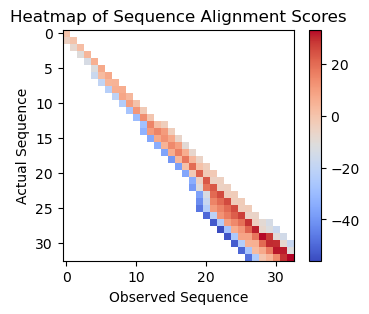

In [20]:
# Call align_global function to perform alignment between test sequences and calculate alignment score
score_matrix, score = align_global(X=actual_test, Y = observed_test, gap_pen = -5) # gap penalty of -5
print('Global alignment score is: ' + str(score))
print()

# Plot a heatmap represent the alignment score matrix (score_mx)
fig, ax = plt.subplots(figsize=(4, 3))

# plot with colorbar
cax = ax.imshow(score_matrix, cmap='coolwarm')
fig.colorbar(cax)

# labels
ax.set_title('Heatmap of Sequence Alignment Scores')
ax.set_ylabel('Actual Sequence')
ax.set_xlabel('Observed Sequence')


plt.show()

The global alignment score matches the one given in the pset, so I think the `align_global` function works.

## 2. check that the -5 score seems reasonable

### Helper functions for simulation

`gen_simulated_seq` generates a simulated DNA sequence from the input sequence using the probabilistic error model given. 

In [21]:
def gen_simulated_seq(input_seq):
    '''
    Takes an actual sequence as input, and uses the probabilistic error model 
    to generate a simulated read from it.

    input (string): (actual) reference DNA sequence 

    output (string): simulated DNA sequence generated using the probabilistic error model
    '''
    input_list = list(input_seq)  # convert string to list of individual characters

    # Initialize an empty list to store the generated sequence
    gen_seq = []
    
    # Define probabilities
    p_insert_T = 0.03125  # probability of inserting a T
    p_delete_T = 0.03125  # probability of deleting a T (only for T bases)
    p_align = 1 - p_insert_T  # probability of aligning for non-T bases

    
    i = 0  # index for iterating through input sequence
    
    # iterate through input sequence
    while i < len(input_list):
        
        # at any step there is a probability of inserting one or more T's
        while np.random.rand() <= p_insert_T: # while loop ensures we keep adding T's according to the probability model 
            gen_seq.append('T')  # append a T to the sequence

        # process current base on the actual sequence
        current_base = input_list[i]

        if current_base == 'T':  # if current base is T, there's a probability of deleting it
            if np.random.rand() <= p_delete_T:  # determine whether T is deleted or not
                i += 1  # move to the next base (T is deleted)
                continue  # skip adding the current T
            else:
                # if not deleted, T is called randomly with 25% chance for each base
                gen_seq.append(np.random.choice(list('ACGT')))  # random base choice for T (uniform probabilities)
        
        else:  # current base of actual sequence is A, C, or G
            if np.random.rand() <= 0.90: # Align with 90% accuracy
                gen_seq.append(current_base)  # correct call, append the current base to the generated sequence
            else:
                # 10% chance of miscall: choose one of the other bases and add it to the generated sequence
                gen_seq.append(np.random.choice([base for base in 'ACGT' if base != current_base]))

        i += 1  # move to the next base

    # at the end of the sequence now (since i = len(input_list)) and no longer in while loop
    # we are allowed to add T's at the end of the sequence
    while np.random.rand() <= p_insert_T:  # while probability condition is true, insert T's in at the end
        gen_seq.append('T')

    # Convert the list back into a string
    return ''.join(gen_seq)

`pos_control_pairs` generates positive control data by creating 32nt sequences and simulating corresponding observed reads using the `gen_simulated_seq` function above.

`neg_control_pairs` generates negative control data by creating two, independent, random 32nt sequences for each pair. 

Both functions allow you to specify the number of pairs of sequences you want to generate. 

In [22]:
# Generate positive control pairs
def pos_control_pairs(num_pairs):
    '''
    Generates positive control pairs by creating 32nt random "actual" sequences and simulating 
    a corresponding "observed" read from each using the gen_simulated_seq function

    input: nump_pairs(int): the number of sequence pairs to generate
    output: seq_pairs(dict): a dictionary where keys are the actual sequences and the values are 
                            corresponding simulated reads
    '''
    # dictionary to store actual sequences and sampled reads
    seq_pairs = {}

    # Loop to generate the specified number of sequences
    for i in range(num_pairs):
        # generate a random 32 nt actual sequence (i.i.d. with uniform base composition)
        act_seq = ''.join(np.random.choice(list('ACGT'), size = 32))

        # make corresponding simulated read sequence using gen_simulated_seq function
        gen_seq = gen_simulated_seq(act_seq)

        # store this pair in the dictionary
        seq_pairs[act_seq] = gen_seq 

    return seq_pairs

# Generate negative control pairs
def neg_control_pairs(num_pairs):
    '''
    Generates negative control pairs by creating two independent random 32nt sequences 
    for each pair, both sampled from an i.i.d. uniform base composition.

    input: nump_pairs(int): the number of sequence pairs to generate
    output: seq_pairs(dict): a dictionary where keys are one random sequence and values are another independently 
                            generated random sequence
    
    '''
    # dictionary to store actual sequences and sampled reads
    seq_pairs = {}

    # Loop to generate the specified number of sequences
    for i in range(num_pairs):
        # generate a random 32 nt actual sequence (i.i.d. with uniform base composition)
        act_seq = ''.join(np.random.choice(list('ACGT'), size = 32))

        # in this case, the corresponding read sequence is also a random i.i.d. 32nt sequence
        read_seq = ''.join(np.random.choice(list('ACGT'), size = 32))

        # store this pair in the dictionary
        seq_pairs[act_seq] = read_seq 

    return seq_pairs

### Testing different gap penalties

Here we were asked to run a simulation where we calculate the alignment scores for 2000 positive control sequence pairs and a 2000 negative control sequence pairs. We can then compare the difference in means between positive and negative data and vary the gap score to optimize for the largest difference in means. 

For each gap score in the list provided, this code generates positive control pairs (using simulated reads) and negative control pairs (using independent random sequences), aligns them using the `align_global` function, and computes the mean alignment scores for both sets. It then calculates the difference in means between the positive and negative controls for each gap score and stores the results for further analysis.

In [23]:
# gap scores to test
gap_score_choices = [0, -2, -4, -5, -6, -8, -10] 

#  list to store results of calculations
results = []

# defining the num_pairs argument
num_pairs = 2000

# iterate over each gap score choice
for gap_score in gap_score_choices:

    ### Positive
    # list to score positive scores
    pos_scores = []
    # generate positive control pairs
    pos_pairs = pos_control_pairs(num_pairs)

    # collect positive control scores by iterating through pairs of sequences
    for act_seq, gen_seq in pos_pairs.items(): # iterate through the dictionary of sequence pairs
        # call the `align_global` and get the alignment score using the current gap_score
        _, score = align_global(X=act_seq, Y = gen_seq, gap_pen = gap_score)
        pos_scores.append(score) # add the current score to the list of scores

    ### Negative
    # list to score negative scores
    neg_scores = []
    # generate negative control pairs
    neg_pairs = neg_control_pairs(num_pairs)

    # collect negative control scores by iterating through pairs of sequences
    for act_seq, gen_seq in neg_pairs.items():
        _, score = align_global(X=act_seq, Y = gen_seq, gap_pen = gap_score)
        neg_scores.append(score)

    # calculate mean scores for positive and negative pairs
    mean_pos_score = np.mean(pos_scores)
    mean_neg_score = np.mean(neg_scores)

    # calculate difference in mean scores
    diff_in_means = mean_pos_score - mean_neg_score

    # store gap score and calculations in list
    results.append({'gap_score': gap_score, 'mean_pos_score': mean_pos_score, 
                    'mean_neg_score': mean_neg_score,'diff_in_means': diff_in_means})

In [24]:
# Convert results list to a dataframe
results_df = pd.DataFrame(results)
results_df

gap_score  mean_pos_score  mean_neg_score  diff_in_means
0          0       33.794605      -16.486225      50.280830
1         -2       30.684190      -29.163260      59.847450
2         -4       28.413400      -34.685310      63.098710
3         -5       26.729030      -36.790810      63.519840
4         -6       25.680645      -37.683740      63.364385
5         -8       23.315765      -39.686310      63.002075
6        -10       21.385385      -40.424195      61.809580

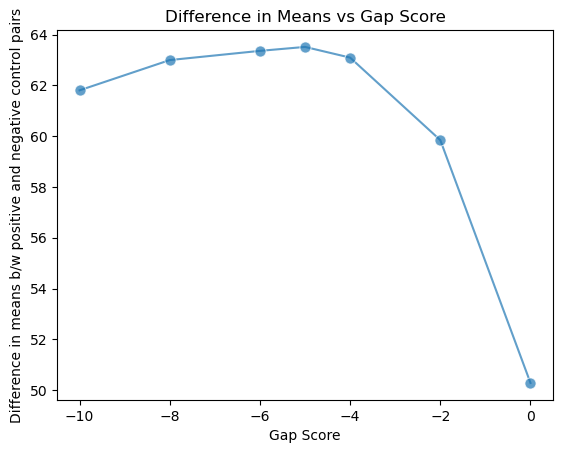

In [25]:
# Plot the difference in means vs. gap score
fig, ax1 = plt.subplots()
sns.lineplot(data = results_df, x = 'gap_score', y = 'diff_in_means', marker='o', markersize=8, alpha=0.7, ax=ax1)

# labels
ax1.set_xlabel('Gap Score')
ax1.set_ylabel('Difference in means b/w positive and negative control pairs')
ax1.set_title('Difference in Means vs Gap Score')

plt.show()

### Why -5 seems like a reasonable gap penalty:
We want to maximize the difference in alignment scores between positive control pairs and negative control pairs. The plot of Difference in Means vs. Gap Score shows that a gap penalty of -5 gives the highest difference in means. Higher penalties (like -10) overly penalize even positive controls, while lower penalties (closer to 0) don't penalize negative alignments enough. Therefore, -5 strikes the right balance and is a reasonable choice in this particular case.

## 3. implement the alignment model for genome scanning

`align_glocal` performs the "glocal" alignment. In `align_global`, both sequences (reference and observed read) are aligned globally, meaning the entire length of both sequences must be aligned. In contrast, `align_glocal` performs global alignment with respect to the read but allows local alignment with respect to the reference, meaning the read must align fully, but it can align to a local region within the reference sequence. In `align_glocal`, the initialization of the first column is set to 0, allowing the alignment to start anywhere in the reference sequence without penalty, enabling local alignment. The termination is also different: here we return the highest score and the position where that score was found. 

In [26]:
# define function to perform global sequence alignment
def align_glocal(X, Y, gap_pen):
    '''
    Function which takes in two sequences, an actual sequence and an observed read, and performs a global/local sequence alignment: 
    global with respect to the read, local with respect to the actual sequence.
    
    input:
        - X (string): (actual) reference sequence of length L
        - Y (string): (observed) read sequence to be aligned to the reference with length M
        - gap_pen: score assigned to an insertion or deletion
        
    output: 
        a tuple containing:
            - score (float): global alignment score for the given sequences
            - score_mx: filled global alignment score matrix for given sequences
    '''
    
    L = len(X) # Length of reference (actual) sequence
    M = len(Y) # Length of reference (actual) sequence

    ### initialization
    score_mx = np.empty((L+1, M+1)) # initialize score matrix
    score_mx[0,0] = 0 # top-left of matrix is 0
    score_mx[1:,0] = 0 # allow alignment to start anywhere in the reference (X) without penalty (local alignment)
    
    # Penalize missing parts of the observed sequence (global alignment) in the first row
    for j in range(1, M+1):
        if Y[j-1] == 'T':  # Apply gap penalty only if Y has a T
            score_mx[0, j] = score_mx[0, j-1] + gap_pen
        else:
            score_mx[0, j] = 0  # No gap penalty for non-T, set to 0

    ### recursion
    # i is for reference sequence X, and j is for observed sequence Y
    for i in range(L): # iterate over all nucleotides in reference (actual) sequence 
        for j in range(M): # iterate over all nucleotides in sequence to be aligned

            # Deletions: if there is a T in the actual sequence, apply gap penalty
            if X[i] == 'T': 
                delete = score_mx[i,j+1] + gap_pen
            else:
                 # Disallow deletion for non-T nucleotides by setting score to -inf
                delete = -np.inf 

            # Insertions: if there is a T in observed sequence, apply gap
            if Y[j] == 'T':
                insert = score_mx[i+1,j] + gap_pen
            else:
                 # Disallow insertion for non-T nucleotides by setting score to -inf
                insert = -np.inf

            # calculate alignment score between X[i] and Y[j] using calculate_sigma
            mis_or_match = score_mx[i,j] + calculate_sigma(X[i],Y[j])

            # calculating max score of the current cell
            score_mx[i+1,j+1] = np.max([insert, delete, mis_or_match])

    ### termination
    # each cell in the last column represents the score of aligning the entire observed read to the reference sequence 
    # up to that position 

    # find the highest score in the last column (last column is M) 
    best_score = np.max(score_mx[:, M]) # M corresponds to entire length of the observed read
    
    # find the end position in the reference sequence where the best score occurs
    best_pos = np.argmax(score_mx[:, M]) # argmax returns the index of the max value in an array

    return best_score, best_pos

## 4. demonstrate proof of principle

In [27]:
# Read fasta file function adapted from pset 1
def read_fasta(file_name):
    """
    Parse a FASTA file and return the DNA sequence as a string

    input: file_name (string): The name of the FASTA file to be parsed 

    output: The DNA sequence from the FASTA file as a string
    """
    with open(file_name) as file: 
        sequence = [] # create an empty list to store the sequence
        for line in file:
            # Skip header lines which start with '>'
            if not line.startswith('>'):
                # remove \n characters and any other spaces so only sequence remains
                sequence.append(line.strip().upper()) 
        return ''.join(sequence)

In [28]:
# Read in the example read 
example_read = read_fasta('example_read.fa')
print(f"Example read sequence: {example_read}")

Example read sequence: GCAGCGGAGGAACCAGACATACTGACGAGCCGT


Let's compare the example read against the three SEA-PHAGE genomes to find the best alignment score and position. For each genome, we need to read in the sequence from a FASTA file, perform the glocal alignment with `align_glocal`, and then print the best alignment score and corresponding position for each genome.

### Note: my sequences downloaded with .txt extensions so I appended '.txt' to the file name to be read. If your files have different extensions, please change it accordingly.

In [29]:
### Read in each of the SEA-PHAGE genomes

# list of the genomes
genomes_list = ['Citius','TPA4','Vulture']

# iterate through each of the three genomes in the genome list
for genome in genomes_list:
    # read in the sequence of the current genome
    genome_seq = read_fasta(genome+'.fa') ### change '.txt' if applicable
    # print(f"Start of {genome} sequence: {genome_seq[:20]}")

    # call `align_glocal` function to perform glocal alignment with a gap penalty of -5
    best_score, best_pos = align_glocal(X=genome_seq, Y=example_read, gap_pen=-5) 

    # Print the results of the alignment
    print(f"\033[1m{genome}\033[0m") # formatting to make the name of the genome bold
    print(f"Best score for {genome}: {best_score}")
    print(f"Best end position for {genome}: {best_pos} \n")

Citius
Best score for Citius: 33.10000000000002
Best end position for Citius: 23902 

TPA4
Best score for TPA4: 9.779999999999994
Best end position for TPA4: 21714 

Vulture
Best score for Vulture: 9.229999999999995
Best end position for Vulture: 18048 



It appears that **Citius** matches the example read most closely because it has the highest alignment score. Therefore, I think the example read came from the Citius phage genome. 

In [30]:
%load_ext watermark
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyter

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

numpy     : 2.1.1
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
jupyter   : 1.1.1

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 22.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 12
Architecture: 64bit

